<a href="https://colab.research.google.com/github/ludmilaexbrayat/recognizing-packagings/blob/master/191111_Model_Trials_GPU_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### /!\ Please note that this notebook is only working in Google Collab with runtime set to GPU

### 0. Notebook Setup

###### Directory Setup

In [1]:
# Cloning Git repo in Google Collab
!git clone https://github.com/ludmilaexbrayat/recognizing-packagings.git
%cd recognizing-packagings/

# Unziping image folder
!unzip data/X_sample.zip
!cp -r X_sample data/

Cloning into 'recognizing-packagings'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 185 (delta 14), reused 21 (delta 7), pack-reused 153
Receiving objects: 100% (185/185), 51.69 MiB | 45.24 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/recognizing-packagings
Archive:  data/X_sample.zip
   creating: X_sample/
  inflating: __MACOSX/._X_sample     
  inflating: X_sample/3045320008494.jpg  
  inflating: __MACOSX/X_sample/._3045320008494.jpg  
  inflating: X_sample/4000607035708.jpg  
  inflating: __MACOSX/X_sample/._4000607035708.jpg  
  inflating: X_sample/3033490690687.jpg  
  inflating: __MACOSX/X_sample/._3033490690687.jpg  
  inflating: X_sample/3439495104707.jpg  
  inflating: __MACOSX/X_sample/._3439495104707.jpg  
  inflating: X_sample/3270190008200.jpg  
  inflating: __MACOSX/X_sample/._3270190008200.jpg  
  inflating: X_sample/4015533025457.jpg  
  inflating: __M

##### Importing Appropriate Packages

In [0]:
# General Packages

import numpy as np
import pickle
import os
import sys
import json
import matplotlib.pyplot as plt
%matplotlib inline


# Torch Specific

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import models,transforms,datasets

from PIL import Image


# Project Specific

sys.path.append(str(os.getcwd() + '/scripts'))
from Preprocessing import MultiLabelDataset

###### Constants and Parameters

In [0]:
BATCH_SIZE = 16
IS_SHUFFLE = True
NUM_WORKERS = 0

LEARNING_RATE = 0.001

COLUMNS = np.array(['Barquette',	
                    'Bocal',	
                    'Boite',
                    'Bouteille',
                    'Brique',
                    'Carton',
                    'Conserve',
                    'Metal',
                    'Papier',
                    'Plastique',
                    'Pot',
                    'Sachet',
                    'Verre'])

###### Machine Setup

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


### 1. Loading Data

##### Importing Data

In [0]:
# Loading the tupple of tensors from the pickle file
with open('data/train_data.pickle', 'rb') as handle:
    train = pickle.load(handle)

# Importing loss matrix
with open("loss_matrix.pickle", "rb") as handle:
  weights_matrix_raw = pickle.load(handle)

weights_matrix = torch.from_numpy(np.array(weights_matrix_raw, dtype='float64')).cuda()

###### Data Loader

In [0]:
# Building the data loader from the tupple of tensors
train_loader = DataLoader(train,
                          batch_size=BATCH_SIZE,
                          shuffle=IS_SHUFFLE,
                          num_workers=NUM_WORKERS)

### 2. Building Model

##### Structure for Transfer Learning

In [0]:
# Loading the pretrained VGG model
model_vgg = models.vgg16(pretrained=True)

# Freezing all layers
for param in model_vgg.parameters():
    param.requires_grad = False

# Adding linear layer
model_vgg.classifier._modules['6'] = torch.nn.Linear(4096, 2048)
model_vgg.classifier._modules['7'] = torch.nn.Linear(2048, 13)
model_vgg.classifier._modules['8'] = torch.nn.Sigmoid()
model_vgg.cuda()

# Defining the optimizer
optimizer_vgg = torch.optim.SGD(model_vgg.classifier.parameters(),lr = LEARNING_RATE)

##### Model Training

In [0]:
# Defining Weighted BCE Loss
def BCEWeightedLoss(outputs, labels, loss_matrix):
  loss = torch.nn.BCELoss(reduce=False)
  loss = loss(outputs, labels)
  loss = torch.mean(loss.matmul(loss_matrix.float()))
  return(loss)

In [50]:
def train_model(model, dataloader, size, epochs=1, optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, classes in train_loader:
            
            inputs_try , labels_try = inputs.to(device), classes.to(device)
            outputs_try = model(inputs_try)
            
            # Using our weighted loss with custom weights matrix
            loss = BCEWeightedLoss(outputs_try, labels_try, weights_matrix)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # statistics
            running_loss += loss.data.item()
        
        epoch_loss = running_loss / size
        print('Loss: {:.4f}'.format(epoch_loss))

# Training the model
train_model(model_vgg, 
    train_loader,
    size=len(train),
    epochs=10,
    optimizer=optimizer_vgg)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Loss: 0.0463
Loss: 0.0357
Loss: 0.0308
Loss: 0.0283
Loss: 0.0269
Loss: 0.0259
Loss: 0.0253
Loss: 0.0249
Loss: 0.0246
Loss: 0.0243


### 3. Model Performance Assesment

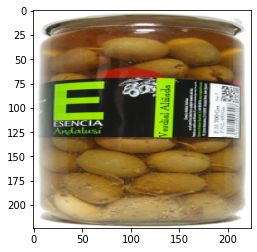


 Raw Predictions:
[0.03700295 0.12320117 0.09590845 0.09360345 0.0509375  0.17832041
 0.03663135 0.08168528 0.03998129 0.48801562 0.07229759 0.07732482
 0.14466766]

 Predicted Labels according to threshold: 
[]

 Predicted Labels according to the 3 higher probs: 
['Carton' 'Plastique' 'Verre']

 True Labels: 
['Bocal' 'Verre']


In [54]:
# Plot prediction vs. true label for a single random image
count = 0
for image, label in train_loader:
  count += 1
  if count == 1:
    image_to_device = image.to(device)
    plt.imshow(np.dstack(image_to_device[0].data.cpu().numpy()))
    plt.show()
    pred = model_vgg(image_to_device)[0].data.cpu().numpy()
    print('\n Raw Predictions:')
    print(pred)
    print('\n Predicted Labels according to threshold: ')
    print(COLUMNS[pred >= 0.5])
    print('\n Predicted Labels according to the 3 higher probs: ')
    print(COLUMNS[np.isin(pred, np.sort(pred)[-3:])])
    print('\n True Labels: ')
    print(COLUMNS[label[0] == 1])
    break